# __Find threshold to determine the MF threshold__

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from importlib import reload
import sys

from MF_plateauTest import MovingAv, rms_peak_ratio
# reload(sys.modules['MF_plateauTest'])

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.max_open_warning']=50

sns.set_style("whitegrid")

# read all threshold for Yes/No values
All_TH = pd.read_csv('../DATA/All_Thresholds.csv', sep='\t')

# sampling rate 10kHz
sr = 10000

# take every N-th row (for skip_rows)
n=2
n_sr=sr/n

# subject to analyze
ID = 13
p_ID = "P"+str(ID)

f_string = f'../DATA/Complete/Res_Cadence_P{ID}'

## Load Labview file
read and downsample to 5kHz

In [124]:
file_name_Lab = f_string+'.txt'

# count the lines
header_end = 23
num_lines = sum(1 for i, l in enumerate(open(file_name_Lab)) if i > header_end)

# the row indices to skip - make sure 0 is not included to keep header
skip_idx = list(range(header_end-1))
skip_idx.extend([x for x in range (header_end, num_lines) if (x-header_end) % n != 0])
lab_df = pd.read_csv(file_name_Lab,
                     skiprows=skip_idx, 
                     delimiter='\t',
                     usecols=['Untitled', 'Untitled 1', 'Untitled 2', 'Current'])
lab_df.columns=['Time', 'MF', 'Dial', 'Current']
lab_df.head()

,Time,MF,Dial,Current
0,0.0,0.268988,1.368328e-12,0.015097
1,NaN,0.489761,5.151331e-11,0.023145
2,NaN,0.334402,3.519078e-10,0.032481
3,NaN,0.146336,1.261025e-09,0.029583
4,NaN,0.661474,3.343170e-09,0.041173


## __Find and extract iterations__
 - find each iterations
 - smooth last second (24-25s) of probe data with moving average over 10 points
 - compute $\frac{rms}{peak}$
 - list all iterations < 0.65 and when phosphene have been perceived

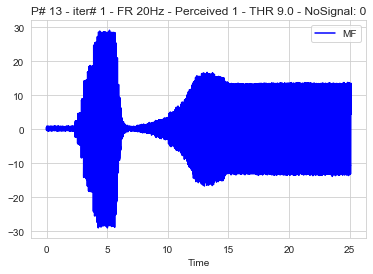

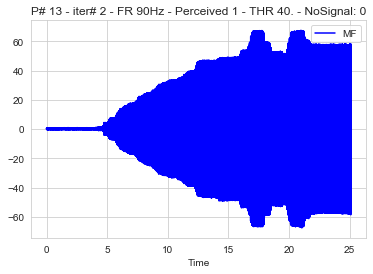

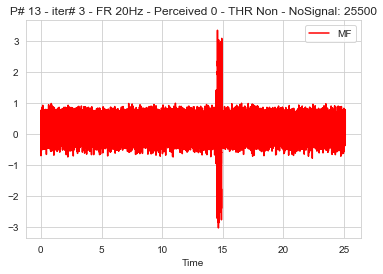

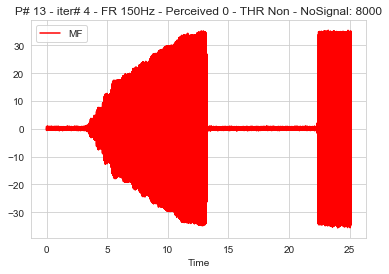

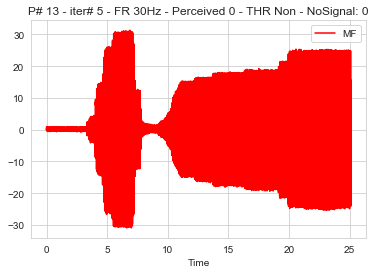

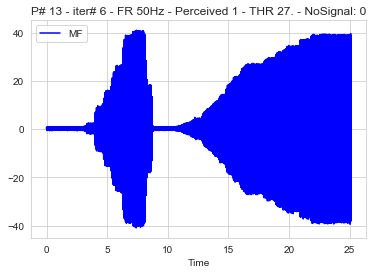

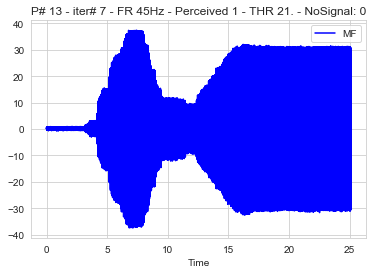

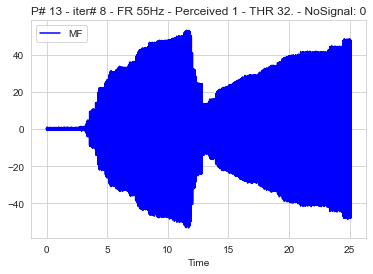

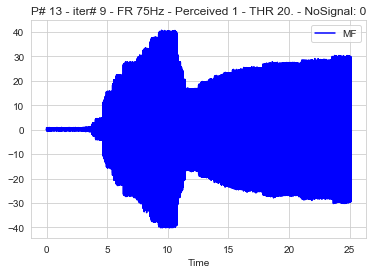

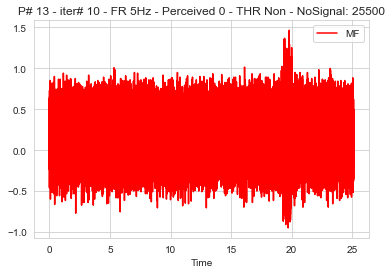

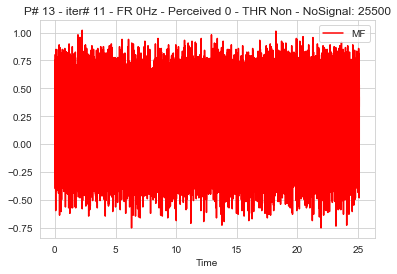

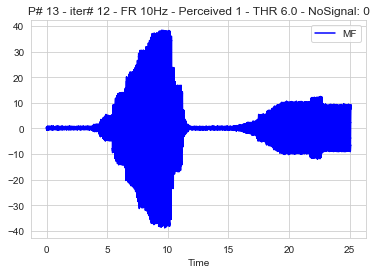

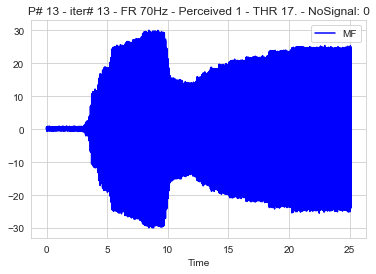

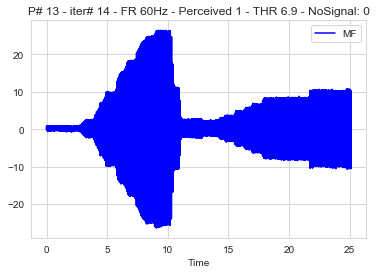

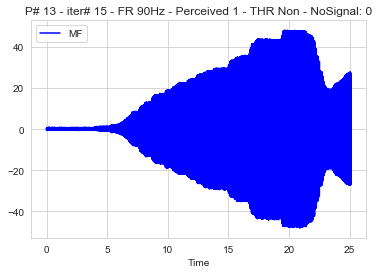

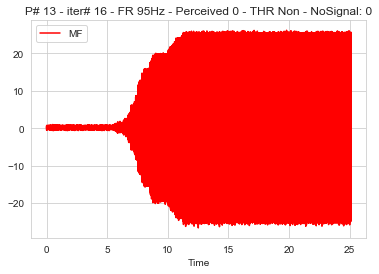

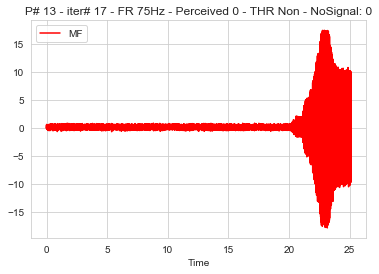

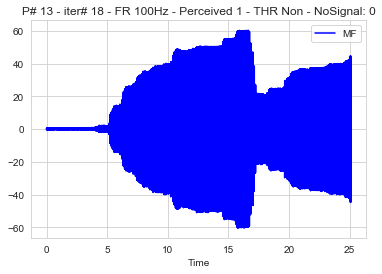

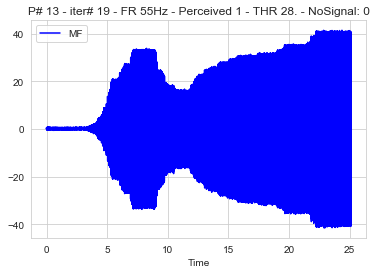

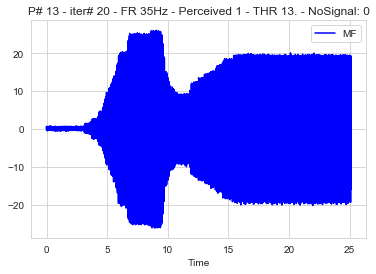

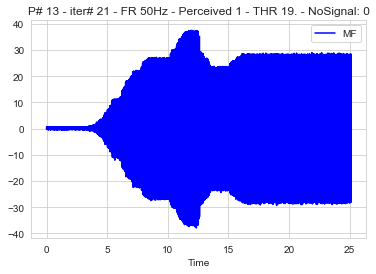

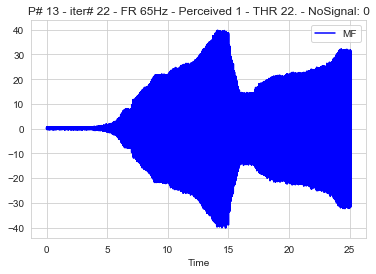

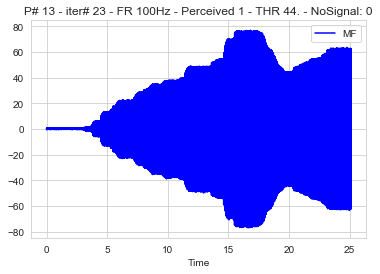

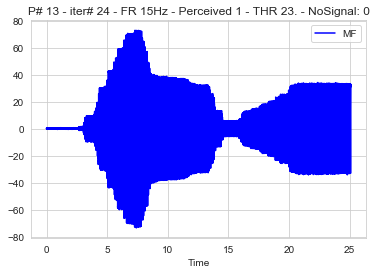

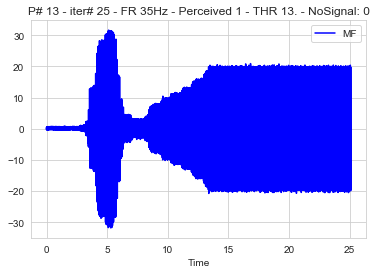

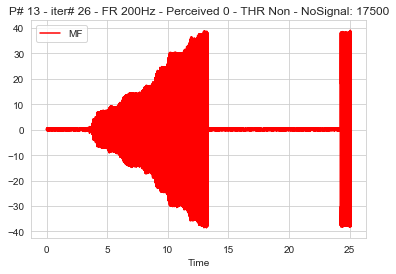

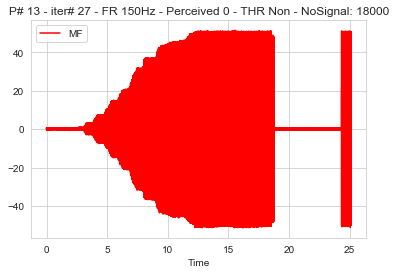

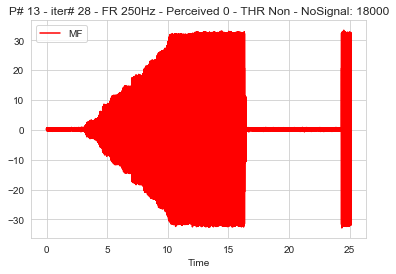

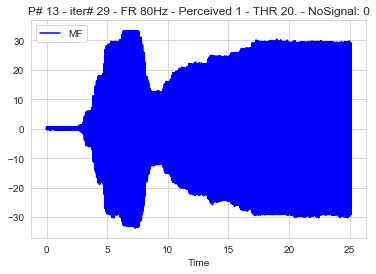

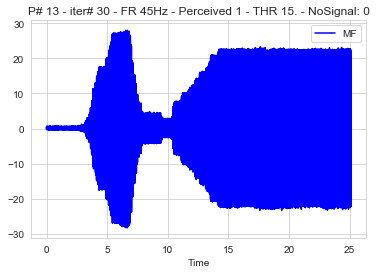

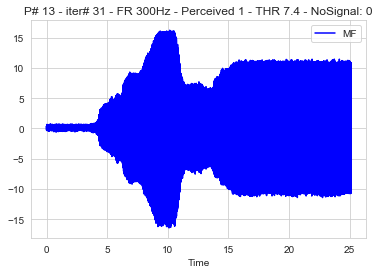

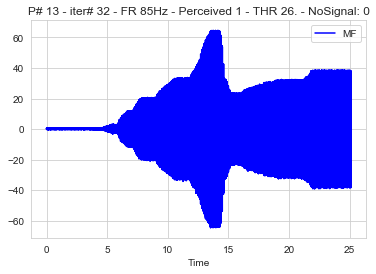

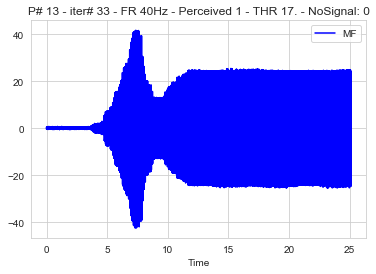

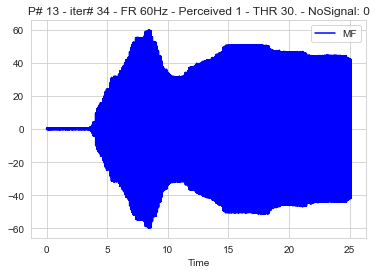

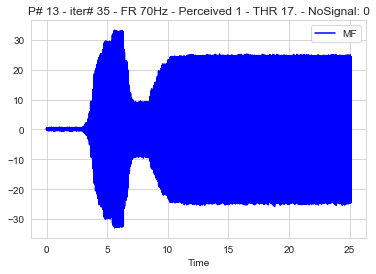

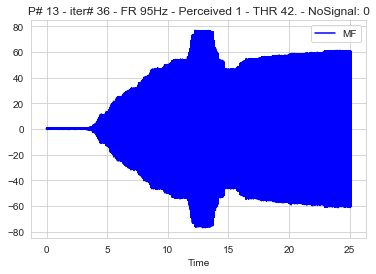

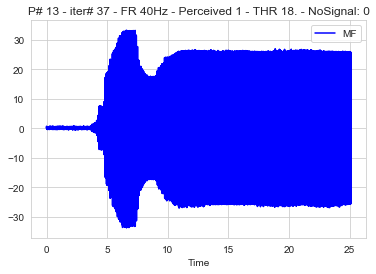

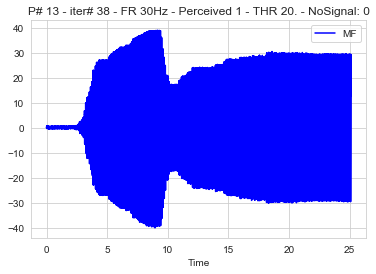

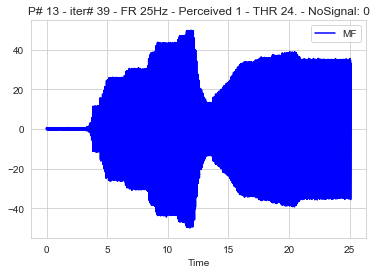

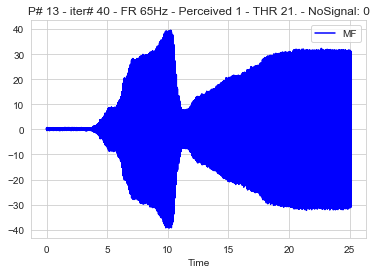

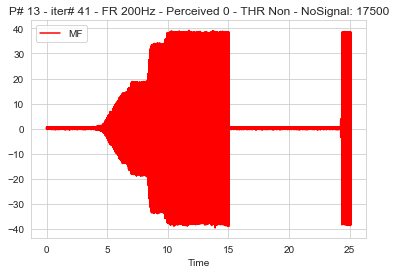

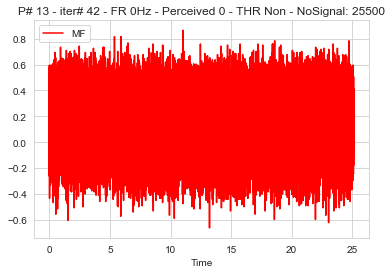

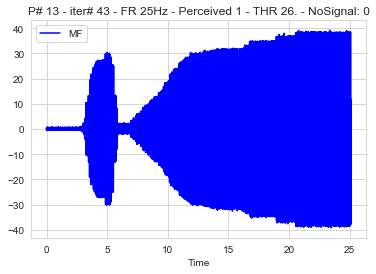

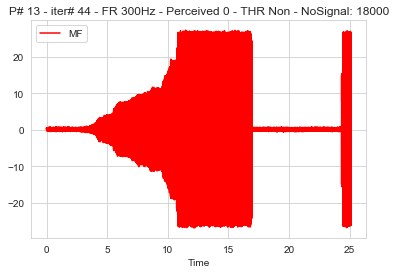

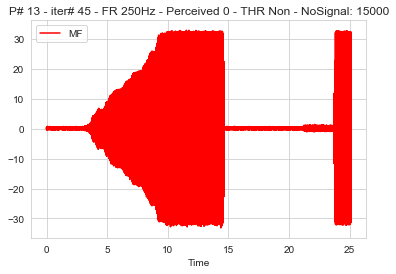

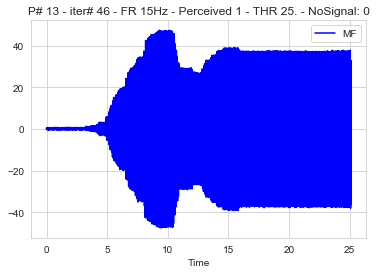

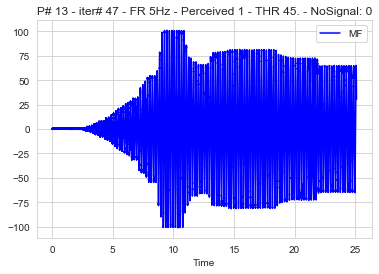

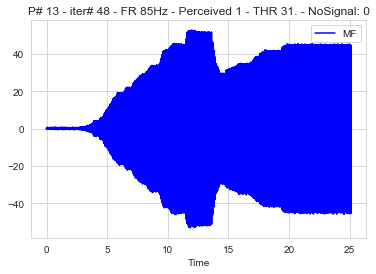

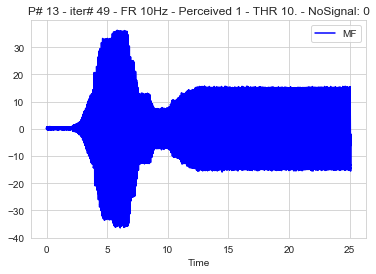

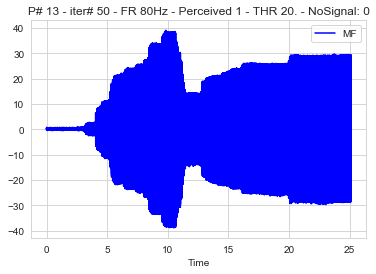

In [165]:
# find all iterations
stLab = lab_df.query('Time == 0')
idxLab = stLab.index.tolist()
idxLab.append(lab_df.index[-1])

# n_MF = pd.DataFrame()
table_threshold = pd.DataFrame(data=All_TH.query(f'ID=="P{ID}"')).reset_index(drop=True)

span = [44]
span = range(50)

for i in span:    
    section_Lab = np.arange(idxLab[:-1][i],idxLab[1:][i])
    
    data = lab_df.loc[section_Lab,:]
    data['Time'] = np.linspace(start=1/n_sr, stop=len(data)*1/n_sr, num=len(data))
    data['Iter_no'] = f'Iter{i+1}'

#     n_MF = n_MF.append(data[['Time', 'MF','Iter_no']])
    
    it_no = i+1
    fr = table_threshold.query(f'Iteration=={it_no}')['Frequency'].item()
    
    len_nosignal = len(data.query('(Time>20) & (Dial<0.05)')) #  used Dial to check signal turned back to 0
    if len_nosignal > n_sr:
        Perceived = 0
    else:
        Perceived = int(table_threshold.loc[i,'Yes/No'])
        
    # compute rms Threshold
    if Perceived:
        subset = data.query('Time > 24')
        rmsf, _, rms_peak = rms_peak_ratio(MovingAv(subset['MF'],10))
        rms, _, _ = rms_peak_ratio(subset['MF']) if rms_peak > 0.65 else (None, None, None)
    else:
        rms = None
        rms_peak = None
            
    table_threshold.loc[i,'Perceived'] = int(Perceived)
    table_threshold.loc[i,'n_Threshold'] = rms
    table_threshold.loc[i,'rms/peak'] = rms_peak
    
    # graph
    if True:
        clrs = 'blue' if Perceived else 'red'
        data.plot(x='Time', y='MF', color=clrs)
        plt.title(f'P# {ID} - iter# {it_no} - FR {fr}Hz - Perceived {Perceived} - THR {str(rms):.3} - NoSignal: {len_nosignal}')


In [167]:
table_threshold.style\
    .applymap(lambda x: 'background: darkorange' if x < 0.65 else " ", subset='rms/peak')\
    .bar(subset=['n_Threshold'], color='lightblue')

,ID,Iteration,Frequency,Threshold,Yes/No,Perceived,n_Threshold,rms/peak
0,P13,1,20,8.974068,1.000000,1.000000,9.066347,0.686299
1,P13,2,90,40.241813,1.000000,1.000000,40.587274,0.702612
2,P13,3,20,nan,0.000000,0.000000,nan,nan
3,P13,4,150,nan,0.000000,0.000000,nan,nan
4,P13,5,30,nan,0.000000,0.000000,nan,nan
5,P13,6,50,28.274846,1.000000,1.000000,27.115044,0.697513
6,P13,7,45,21.369477,1.000000,1.000000,21.546089,0.698612
7,P13,8,55,33.469683,1.000000,1.000000,32.616009,0.677467
8,P13,9,75,20.645729,1.000000,1.000000,20.829830,0.695385
9,P13,10,5,nan,0.000000,0.000000,nan,nan


## __Test $\frac{rms}{peak}$ over sinus signal__
create sinus with ramp and noise to test the treshold of rms/peak ratio to detect a stable signal

0.6230989637215566

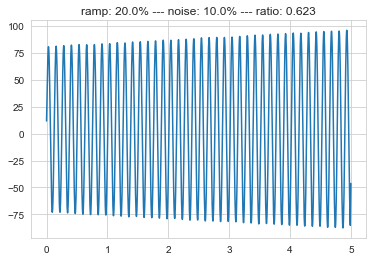

In [103]:
A = 80
duration=5
sr = 5000
t = np.linspace(0,duration,sr*duration)
fr = 50

coef_ramp=0.2
ramp = np.linspace(A,A+A*coef_ramp,len(t))

coef_noise=0.1
noise = (A*coef_noise*np.random.random(len(t)))


test_sin = ramp*np.sin(fr*t)+noise
test_sin = MovingAv(test_sin, 100)

rms = np.sqrt(np.mean(test_sin**2))
peak = np.max(test_sin)
r = rms/peak

plt.figure()
plt.plot(t, test_sin)
plt.title(f'ramp: {coef_ramp*100}% --- noise: {coef_noise*100}% --- ratio: {r:.3}')

r